## Практическое задание к уроку 4 по теме "Тематическое моделирование. EM-алгоритм".

*Взять ноутбук с вебинара изменить тематики (минимум 3 тематики
взять) построить тематическую модель, попробовать проинтерпретировать
полученные тематики. Насколько они похожи на то что вы выделяли из корпуса.
Возможно большее количество тематик так же хорошо интерпретируется проверьте
это. Подберите оптимальное количество тематик с точки зрения интерпретации
результатов. Не забывайте чтобы получить хорошие тематики надо хорошо почистить
тексты.*

Загрузим библиотеки и датасет:

In [1]:
%matplotlib inline

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd; pd.set_option('max_colwidth', None)
from pymorphy2 import MorphAnalyzer
from razdel import tokenize
import re
from stop_words import get_stop_words
from string import punctuation
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
RANDOM_STATE = 29
NUM_THREADS = 12

In [3]:
df = pd.read_csv('../../Теория/Lesson_4/lenta-ru-news.csv', usecols=[2])
df.shape
df.head(3)

,text
0,"Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее."
1,"Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Все они продолжат выступление на Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12 декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список, полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском Обертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм» в мировом биатлоне. В Австрии прием допинга — уголовное преступление. Максимальное наказание за его употребление — три года тюрьмы."
2,"Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия."


Для увеличения скорости обработки текста и обучения моделей сделаем  
выборку в 50 тыс. текстов:

In [4]:
df = df.sample(50000, random_state=RANDOM_STATE)

Загрузим стопслова:

In [5]:
sw = get_stop_words('russian')

Лемматизацию будем проводить с помощью pymorphy2:

In [6]:
lemmatizer = MorphAnalyzer()

Сделаем обработку текста:

In [7]:
def process_text(text):
        
    # Чистим пунктуацию
    text = re.sub(fr'[{punctuation}]+', ' ', text)
    
    # Убираем всё, не являющееся набором букв, в т.ч. цифры
    text = ' '.join(word for word in text.split() if word.isalpha())
    
    # Токенизация с помощью библиотеки razdel
    text = [token.text for token in list(tokenize(text))]
    
    # Лемматизация
    text = [lemmatizer.parse(word)[0].normal_form for word in text]
    
    # Убираем стопслова
    text = [word for word in text if word not in sw]
    
    # Возвращаем обработанный текст
    return text

In [8]:
with Pool(NUM_THREADS) as p:
    df['text'] = tqdm(p.imap(process_text, df['text']), total=len(df))

100%|████████████████████████████████████| 50000/50000 [03:39<00:00, 228.02it/s]


In [9]:
df.head(3)

,text
58102,"[американский, актёр, марк, хэмилла, известный, роль, люк, скайоукер, фантастический, киноэпопея, поведать, быстрый, способ, стать, знаменитость, слово, сделать, шаг, передавать, портал, bt, среда, август, дело, шаг, взорвать, звезда, смерть, заслужить, благодарность, миллион, остаться, отметить, хэмилла, укрепить, свой, образ, благодетель, герой, сделать, люк, перевоплотиться, джокер, воплощение, подлость, порочность, удаться, пройти, шаг, лёгкий, продолжить, актёр, напечатать, свой, образ, куча, товар, pez, дозатор, игрушка, конфета, детский, нижний, бельё, underoos, электрический, зубной, щётка, спальный, хэмилла, отметить, постичь, судьба, искренне, благодарный, получить, признание, космический, станция, способный, уничтожать, целый, планета, люк, скайуокер, взрывать, фильм, франшиза, война, эпизод, iv, новый, помимо, съёмка, фантастический, эпопея, хэмилла, озвучивать, злодей, джокер, ...]"
670990,"[тысяча, американский, десантник, осуществить, среда, парашютный, высадка, север, ирак, сообщать, cbs, news, район, высадка, самолёт, палубный, авиация, вмс, сша, нанести, ракетный, удар, позиция, иракский, войско, информация, представитель, американский, командование, боец, парашютный, десантный, бригада, высадиться, территория, контролировать, курдский, племя, прибыть, подразделение, занять, аэродром, башур, bashur, километр, юг, граница, турция, настоящий, готовиться, принятие, новый, сила, коалиция, подобный, действие, шаг, открытие, ирак, северный, фронт, американский, войско, помочь, снизить, напряжённость, регион, возникнуть, перемещение, турция, свой, подразделение, граница, ирак, район, населить, курд, заявление, анкара, сделать, частность, избежать, гуманитарный, катастрофа, граница, предотвратить, создание, независимый, курдский, государство, северный, часть, ирак, заселять, преимущественно, курд, граница, зона, запретный, полёт, ...]"
530791,"[полузащитник, сборная, англия, дэвид, бекхэм, заявить, собираться, завершать, карьера, национальный, команда, несмотря, англичанин, суметь, пробиться, евро, футболист, пообещать, продолжить, выступать, сборная, вывести, финальный, стадия, чемпионат, мир, юар, сообщать, afp, бекхэм, считать, достаточно, опыт, страсть, помочь, свой, команда, решить, задача, выход, чм, полузащитник, сыграть, матч, сборная, англия, надеяться, преемник, стив, макларен, пост, главное, тренер, найти, место, состав, настоящий, бекхэм, находиться, австралия, вторник, ноябрь, состояться, товарищеский, матч, команда, англичанин, лос, анджелес, гэлаксить, местный, клуб, сидней, игра, состояться, дебют, руда, гуллита, пост, главное, тренер, гэлаксить]"


Создадим словарь:

In [10]:
dictionary = Dictionary(df['text'])
len(dictionary)

140176

Уберём из словаря очень редкие и очень частые слова:

In [11]:
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=None)
len(dictionary)

35724

Создадим корпус текстов для обучения модели, используя словарь:

In [12]:
corpus = [dictionary.doc2bow(text) for text in df['text']]

Зададим первоначальное количество тем:

In [13]:
NUM_TOPICS = 5

Обучим модель:

In [14]:
%%time

model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, random_state=RANDOM_STATE)

CPU times: user 31.1 s, sys: 100 ms, total: 31.2 s
Wall time: 31.2 s


Проверим, насколько модель научилась разделять тематики:

In [15]:
def get_topics_words(model, n_topics):
    
    x = model.show_topics(num_topics=n_topics, num_words=10, formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

    for topic, words in topics_words:
        print(f"topic_{topic}: " + " ".join(words))

In [16]:
get_topics_words(model, NUM_TOPICS)

topic_0: компания новый свой сша the американский учёный тысяча сайт миллион
topic_1: процент компания россия доллар миллиард рубль российский миллион страна сша
topic_2: матч свой команда стать фильм сообщать сборная клуб россия мир
topic_3: президент россия суд дело заявить свой глава украина слово решение
topic_4: сообщать произойти находиться город полиция погибнуть результат данные сообщить задержать


В целом, модель неплохо справляется. Можно без особого труда дать названия  
почти всем получившимся темам.

Теперь посмотрим значение средней когерентности модели:

In [17]:
CoherenceModel(model, texts=df['text'], dictionary=dictionary).get_coherence()

0.45120923334042706

Попробуем выявить количество тематик, дающее наибольшую метрику  
средней когерентности:

In [18]:
ns = (3, 5, 10, 15, 20, 25, 30, 40, 50)
scores = []

for n_topics in tqdm(ns):
    model = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, 
                     passes=2, random_state=RANDOM_STATE)
    
    score = CoherenceModel(model, texts=df['text'], dictionary=dictionary).get_coherence()
    scores.append(score)

100%|█████████████████████████████████████████████| 9/9 [09:24<00:00, 62.77s/it]


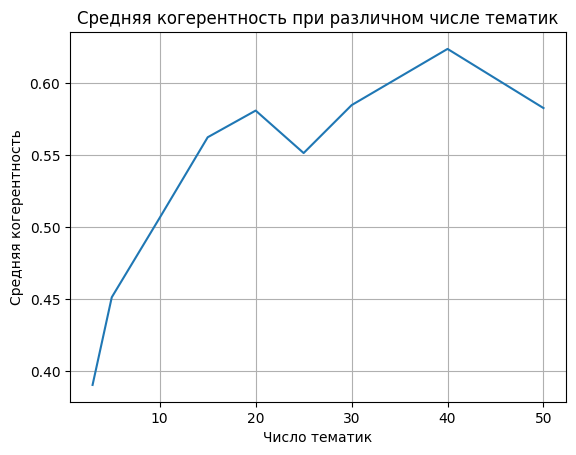

In [19]:
plt.plot(ns, scores)
plt.title('Средняя когерентность при различном числе тематик')
plt.xlabel('Число тематик')
plt.ylabel('Средняя когерентность')
plt.grid()
plt.show()

Наибольшую метрику показывает модель с разделением на 40 тематик.  
Оценим визуально её качество:

In [20]:
NUM_TOPICS = 40

In [21]:
model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, random_state=RANDOM_STATE)

In [22]:
get_topics_words(model, NUM_TOPICS)

topic_0: сша американский нью штат йорк the press associated new times
topic_1: компания акция газета директор свой крупный российский сделка банк решение
topic_2: украина украинский киев крым республика донецкий язык порошенко народный рада
topic_3: москва город строительство проект центр петербург московский площадь метр санкт
topic_4: израиль израильский аль газета палестинский the британский польский египет сообщать
topic_5: суд дело убийство обвинение адвокат свой признать бывший преступление приговорить
topic_6: депутат партия выборы парламент госдума закон законопроект голос голосование член
topic_7: ракета корабль космический истребитель самолёт аппарат ввс полёт запуск су
topic_8: процент доллар миллиард рубль банк нефть цена россия составить рынок
topic_9: фильм картина актёр режиссёр роль главный выйти стать лента сериал
topic_10: российский россия олимпийский франция спортсмен мир международный французский игра спорт
topic_11: погибнуть город боевик результат сообщать терак

Получили много распределений слов в темах, у большинства из которых легко  
обозначить их направленность. Однако некоторые темы субъективно пересекаются  
с другими, например, связанные с экономикой. Возможно, стоит остановиться на  
предыдущем пиковом значении метрики, достигаемом при 20 тематиках. Но это,  
в основном, зависит от конкретной задачи нашего моделирования.